In [1]:
!pip install torch_geometric PyTDC

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached pytdc-1.1.15.tar.gz (154 kB)
  Preparing metadata (setup.py) ... done
  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB)
  Using cached dataclasses-0.6-py3-none-any.whl.metadata (3.0 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata (4.9 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached transformers-4.50.3-py3-none-any.whl.metadata (39 kB)
  Using cached cellxgene_census-1.15.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached gget-0.29.2-py3-none-any.whl.metadata (7.9 kB)
  Using cached rdkit-2023.9.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached tiledbsoma-1.17.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (7.0 kB)
  Using cached tiledbsoma-1.11.4-cp311-cp311-manylinux_2_17_x86_64.ma

# **(1) Preparing data set from theuraputics data common name DAVIS**

In [1]:
from tdc.multi_pred import DTI
data=DTI(name='DAVIS')
df=data.get_data()
print(df)

Downloading...
100%|██████████| 21.4M/21.4M [00:00<00:00, 46.8MiB/s]
Loading...
Done!


        Drug_ID                                           Drug Target_ID  \
0      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      AAK1   
1      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ABL1p   
2      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      ABL2   
3      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ACVR1   
4      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12    ACVR1B   
...         ...                                            ...       ...   
25767    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1       YES   
25768    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1      YSK1   
25769    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1      YSK4   
25770    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1       ZAK   
25771    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1     ZAP70   

                                                  Target        Y  
0      MKKFFDSRREQG

In [2]:
def classify(kd):
  if kd < 1000:
    return 1
  else:
    return 0

df['label']=df['Y'].apply(classify)
print(df['label'])

0        1
1        0
2        0
3        0
4        0
        ..
25767    0
25768    0
25769    0
25770    0
25771    0
Name: label, Length: 25772, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
#
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Then, split the remaining data into training and validation sets (validation: 20% of original)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)
# train_df = 60%, val_df = 20%, test_df = 20%
print(train_df.shape)

(15462, 6)


In [4]:
# creating dictonary for protein encoding
import torch
aminomap={a: i+1 for i,a in enumerate('ACDEFGHIKLMNPQRSTVWY')}

def encode_protein(sqn):
  # sqn to list by aminomap
  maxlen=512
  sqn_idx=[]
  for a in sqn:
    sqn_idx+=[aminomap.get(a,0)]
  if len(sqn) < maxlen:
    sqn_idx+=[0]*(maxlen-len(sqn))
  sqn_idx = sqn_idx[:maxlen]
  return torch.tensor(sqn_idx,dtype=torch.long)

In [5]:
# converting SMILE to Graph
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdmolops
def atomfeatures(atom):
  return [
       atom.GetAtomicNum(),                   # 1. Atomic number
       atom.GetDegree(),                      # 2. Number of bonded neighbors
       atom.GetFormalCharge(),                # 3. Formal charge
       atom.GetNumExplicitHs(),               # 4. Number of H atoms
       int(atom.GetIsAromatic()),             # 5. Aromatic or not (1/0)
       int(atom.GetHybridization()),          # 6. Hybridization state
       int(atom.GetChiralTag())               # 7. Chirality
  ]
def graphconvert(smile):
  mol=Chem.MolFromSmiles(smile)
  temp=[]
  for i,a in enumerate(mol.GetAtoms()):
    temp.append(atomfeatures(a))
  x=torch.tensor(temp,dtype=torch.float32)
  edge_index=torch.tensor(rdmolops.GetAdjacencyMatrix(mol).nonzero(),dtype=torch.long)
  return x,edge_index


In [6]:
from torch_geometric.data import Data, Dataset
class GNN_CNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smile = row['Drug']
        seq = row['Target']
        label = row['label']
        label = torch.tensor([label], dtype=torch.long)
        x, edge_index = graphconvert(smile)
        protein_tensor = encode_protein(seq).unsqueeze(0)
        data = Data(x=x, edge_index=edge_index, y=label)
        data.protein = protein_tensor
        return data

In [7]:

train_dataset = GNN_CNNDataset(train_df)
val_dataset = GNN_CNNDataset(val_df)
test_dataset = GNN_CNNDataset(test_df)

# (2) Model creation GNN(atoms/molecule) + CNN(protein)**

In [25]:
import torch
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, BatchNorm ,GINConv
from sklearn.metrics import accuracy_score
class GINLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        nn_seq = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
        self.conv = GINConv(nn_seq)
        self.bn = BatchNorm(out_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.bn(x)
        return x
class GINEncoder(nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()
        self.gin1 = GINLayer(in_channels, hidden)
        self.gin2 = GINLayer(hidden, hidden)
        self.gin3 = GINLayer(hidden, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.gin1(x, edge_index)
        x = self.gin2(x, edge_index)
        x = self.gin3(x, edge_index)
        x = global_mean_pool(x, batch)
        return x
class CNNEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, out_channels):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_channels, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, seq):
        x = self.embed(seq.long()).transpose(1, 2)  # (B, embed_dim, 2000)
        x = torch.relu(self.bn1(self.conv1(x)))     # (B, 64, 2000)
        x = torch.relu(self.bn2(self.conv2(x)))     # (B, out_channels, 2000)
        x = self.pool(x).squeeze(-1)                # (B, out_channels)
        return x

class GIN_CNN_Model(nn.Module):
    def __init__(self, atom_feat_dim, prot_vocab_size):
        super().__init__()
        self.gnn = GINEncoder(atom_feat_dim, 64, 128)
        self.cnn = CNNEncoder(vocab_size=prot_vocab_size, embed_dim=32, out_channels=128)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, batch):
        drug_emb = self.gnn(batch.x, batch.edge_index, batch.batch)
        prot_emb = self.cnn(batch.protein)
        out = torch.cat([drug_emb, prot_emb], dim=1)
        return self.fc(out)


In [10]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
for batch in train_loader:
    print(batch.protein.shape)
    break

torch.Size([32, 512])


In [30]:
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import time
model = GIN_CNN_Model(atom_feat_dim=7, prot_vocab_size=21)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
num_epochs=9
for epoch in range(num_epochs):
    print('epoch == ',epoch+1)
    model.train()
    i=1
    for batch in train_loader:
      optimizer.zero_grad()
      logits = model(batch)
      loss = criterion(logits.view(-1), batch.y.float())
      loss.backward()
      if i%100==0:
        print(f"|| training Loss from {(32*i)} samples: {loss.item():.4f}" )
      optimizer.step()
      i+=1
      print(f"\r\033[KPercent epoch {( i*100/485):.4f} % || training Loss from {(i)} samples: {loss.item():.4f} ", end='', flush=True)
    model.eval()
    with torch.no_grad():
      all_preds, all_labels = [], []
      for batch in val_loader:
            logits = model(batch)
            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            labels = batch.y.int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"cross-validation Accuracy: {accuracy:.4f}")


epoch ==  1
Percent epoch 20.6186 % || training Loss from 100 samples: 0.4026 || training Loss from 3200 samples: 0.3951
Percent epoch 41.2371 % || training Loss from 200 samples: 0.3147 || training Loss from 6400 samples: 0.4303
Percent epoch 61.8557 % || training Loss from 300 samples: 0.2347 || training Loss from 9600 samples: 0.3570
Percent epoch 82.4742 % || training Loss from 400 samples: 0.3416 || training Loss from 12800 samples: 0.3065
Percent epoch 100.0000 % || training Loss from 485 samples: 0.2081 cross-validation Accuracy: 0.8221
epoch ==  2
Percent epoch 20.6186 % || training Loss from 100 samples: 0.5882 || training Loss from 3200 samples: 0.3088
Percent epoch 41.2371 % || training Loss from 200 samples: 0.3838 || training Loss from 6400 samples: 0.2512
Percent epoch 61.8557 % || training Loss from 300 samples: 0.2607 || training Loss from 9600 samples: 0.5394
Percent epoch 82.4742 % || training Loss from 400 samples: 0.3009 || training Loss from 12800 samples: 0.4764
P

## **(3) EVALUATION OF MODEL**

training set Accuracy: 0.8881
[[12315   545]
 [ 1185  1417]]


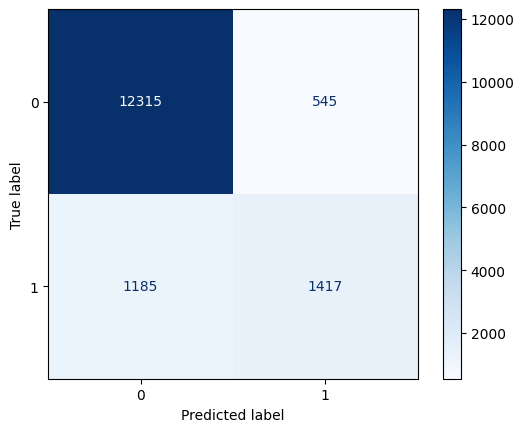

In [37]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:  # Use the correct DataLoader from torch_geometric
         logits = model(batch)
         preds = (torch.sigmoid(logits) > 0.6).int().cpu().numpy()
         labels = batch.y.int().cpu().numpy()
         all_preds.extend(preds)
         all_labels.extend(labels)
    accuracy = accuracy_score(all_labels, all_preds)
print(f"training set Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
print(cm)
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

test Accuracy: 0.8739
[[4089  214]
 [ 436  416]]
0.5614035087719298


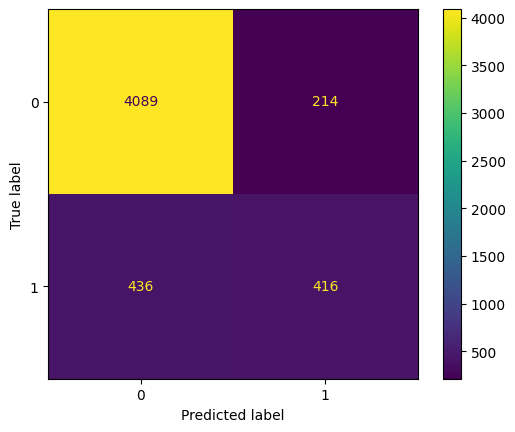

In [45]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:  # Use the correct DataLoader from torch_geometric
         logits = model(batch)
         preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
         labels = batch.y.int().cpu().numpy()
         all_preds.extend(preds)
         all_labels.extend(labels)
    accuracy = accuracy_score(all_labels, all_preds)
print(f"test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , f1_score

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
print(cm)
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(f1_score(all_labels,all_preds))
plt.show()